# Exercise - 交通事故理赔审核预测


这个比赛的链接：http://sofasofa.io/competition.php?id=2


* 任务类型：二元分类

* 背景介绍：在交通摩擦（事故）发生后，理赔员会前往现场勘察、采集信息，这些信息往往影响着车主是否能够得到保险公司的理赔。训练集数据包括理赔人员在现场对该事故方采集的36条信息，信息已经被编码，以及该事故方最终是否获得理赔。我们的任务是根据这36条信息预测该事故方没有被理赔的概率。

* 数据介绍：训练集中共有200000条样本，预测集中有80000条样本。 
![data_description](images/data_description.png)

* 评价方法：Precision-Recall AUC


## Demo code


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# read data
homePath = "data"
trainPath = os.path.join(homePath, "train.csv")
testPath = os.path.join(homePath, "test.csv")
submitPath = os.path.join(homePath, "sample_submit.csv")
trainData = pd.read_csv(trainPath)
testData = pd.read_csv(testPath)
submitData = pd.read_csv(submitPath)

参照数据说明，CaseID这列是没有意义的编号，因此这里将他丢弃。

~drop()函数：axis指沿着哪个轴，0为行，1为列；inplace指是否在原数据上直接操作


In [46]:
# 去掉没有意义的一列
trainData.drop("CaseId", axis=1, inplace=True)
testData.drop("CaseId", axis=1, inplace=True)

# 快速了解数据

~head()：默认显示前5行数据，可指定显示多行，例如.head(15)显示前15行


In [30]:
trainData.head(15)


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Evaluation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,2,2,2,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,3,2,3,1,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,4,2,4,1,0,0,1,1,0
5,0,0,0,0,0,0,0,0,0,0,...,1,2,3,5,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,3,1,6,1,0,0,1,1,1
7,0,0,0,0,0,0,0,0,0,0,...,1,3,1,3,1,0,0,1,1,1
8,0,0,0,0,0,0,0,2,0,0,...,0,2,1,2,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,2,1,7,1,0,0,0,0,0


显示数据简略信息，可以每列有多少非空的值，以及每列数据对应的数据类型。



In [31]:
trainData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 37 columns):
Q1            200000 non-null int64
Q2            200000 non-null int64
Q3            200000 non-null int64
Q4            200000 non-null int64
Q5            200000 non-null int64
Q6            200000 non-null int64
Q7            200000 non-null int64
Q8            200000 non-null int64
Q9            200000 non-null int64
Q10           200000 non-null int64
Q11           200000 non-null int64
Q12           200000 non-null int64
Q13           200000 non-null int64
Q14           200000 non-null int64
Q15           200000 non-null int64
Q16           200000 non-null int64
Q17           200000 non-null int64
Q18           200000 non-null int64
Q19           200000 non-null int64
Q20           200000 non-null int64
Q21           200000 non-null int64
Q22           200000 non-null int64
Q23           200000 non-null int64
Q24           200000 non-null int64
Q25           200000 non-

~hist():绘制直方图，参数figsize可指定输出图片的尺寸。


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcce92a6f28>,
      dtype=object)

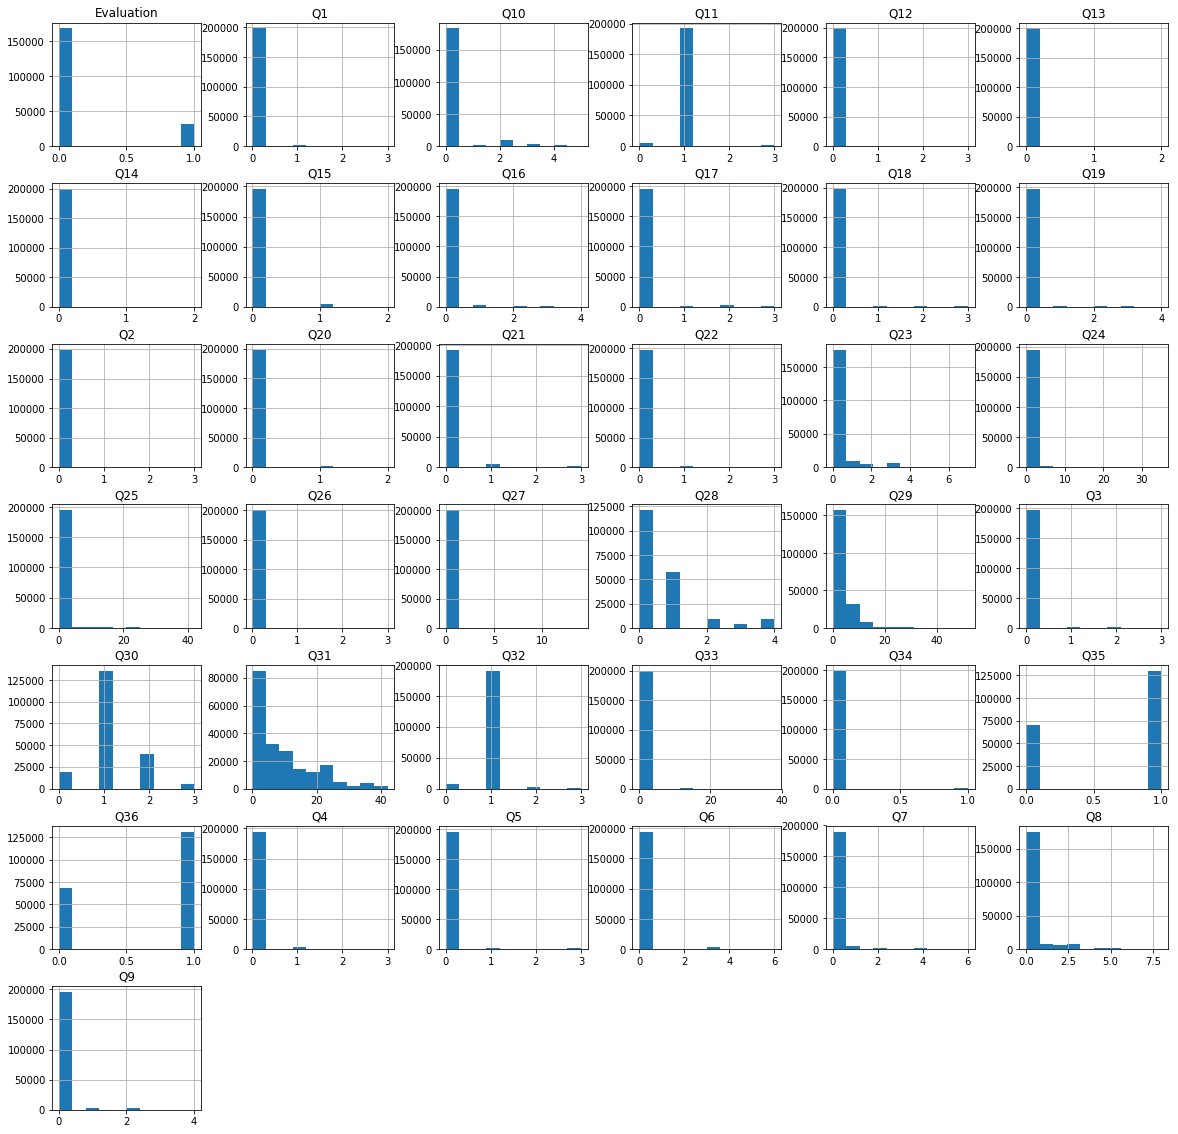

In [32]:
trainData.hist(figsize=(20, 20))


想要了解特征之间的相关性，可计算相关系数矩阵。然后可对某个特征来排序。



In [33]:
corr_matrix = trainData.corr()
corr_matrix["Evaluation"].sort_values(ascending=False) # ascending=False 降序排列

Evaluation    1.000000
Q28           0.410700
Q30           0.324421
Q36           0.302709
Q35           0.224996
Q34           0.152743
Q32           0.049397
Q21           0.034897
Q33           0.032248
Q13           0.023603
Q8            0.021922
Q19           0.019694
Q20           0.013903
Q4            0.011626
Q27           0.004262
Q23           0.002898
Q7            0.001143
Q31          -0.000036
Q14          -0.000669
Q29          -0.002014
Q10          -0.002711
Q12          -0.005287
Q1           -0.006511
Q16          -0.007184
Q18          -0.007643
Q26          -0.008188
Q11          -0.009252
Q24          -0.010891
Q22          -0.011821
Q25          -0.012660
Q6           -0.016072
Q2           -0.018307
Q15          -0.019570
Q9           -0.021261
Q5           -0.023893
Q3           -0.026349
Q17          -0.028461
Name: Evaluation, dtype: float64

从训练集中分离标签

In [47]:
y = trainData['Evaluation']
trainData.drop("Evaluation", axis=1, inplace=True)

使用K-Means训练模型

KMeans()：
* `n_clusters`指要预测的有几个类；
* `init`指初始化中心的方法，默认使用的是`k-means++`方法，而非经典的K-means方法的随机采样初始化，当然你可以设置为random使用随机初始化；
* `n_jobs`指定使用CPU核心数，-1为使用全部CPU。

In [55]:
# do k-means
from sklearn.cluster import KMeans
est = KMeans(n_clusters=2, init="k-means++", n_jobs=-1)
est.fit(trainData, y)

y_train = est.predict(trainData)
y_pred = est.predict(testData)

# 保存预测的结果
submitData['Evaluation'] = y_pred
submitData.to_csv("submit_data.csv", index=False)

In [58]:
# calculate accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y, y_train)
print("acc_train = %f" % (acc_train))

acc_train = 0.682140


## 随机森林

使用K-means可能得到的结果没那么理想。在官网上，举办方给出了两个标杆模型，效果最好的是随机森林。以下是代码，读者可以自己测试。



In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 读取数据
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submit = pd.read_csv("data/sample_submit.csv")

# 删除id
train.drop('CaseId', axis=1, inplace=True)
test.drop('CaseId', axis=1, inplace=True)

# 取出训练集的y
y_train = train.pop('Evaluation')

# 建立随机森林模型
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(train, y_train)
y_pred = clf.predict_proba(test)[:, 1]

# 输出预测结果至my_RF_prediction.csv
submit['Evaluation'] = y_pred
submit.to_csv('my_RF_prediction.csv', index=False)



In [65]:
# freature importances
print(clf.feature_importances_)

# Train accuracy
from sklearn.metrics import accuracy_score
y_train_pred = clf.predict(train)
print(y_train_pred)

acc_train = accuracy_score(y_train, y_train_pred)
print("acc_train = %f" % (acc_train))

[0.00177294 0.00207449 0.00187096 0.00471492 0.00443815 0.0029538
 0.00364967 0.00652341 0.00235713 0.00739511 0.00245106 0.00106103
 0.0007513  0.00090631 0.00150727 0.0037793  0.00183821 0.00196833
 0.00209665 0.00726069 0.00816243 0.00107563 0.00559247 0.00766561
 0.00760666 0.00028462 0.00025573 0.18472067 0.25559838 0.21436631
 0.0425301  0.00662325 0.00297955 0.03148822 0.03907383 0.13060584]
[0 0 0 ... 0 0 0]
acc_train = 0.931525
